## Summary

The dataset contains ~1,600 extracts (paragraphs or other snippets) from Terms of Service and Privacy Policy documents across popular web services. These have been curated by the ToS:DR project as being relevant and important to the end user, either for reasons good or bad, and segregated into topics, points (meaning), and good/bad/neutral status.

The end goal is to make these documents easier to digest/understand. This will be achieved by the following:
 - predicting topic based on word content
 - predicting whether terms are classified as good/bad/neutral, to potentially warn the user of any negative terms contained within.

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [338]:
df = pd.read_csv('revised_points.csv', header = 'infer')

In [339]:
df.shape

(1688, 17)

In [340]:
df

,id,needModeration,Status,services,title,Summary,Source,quoteEnd,quoteStart,quoteText,Sourcelink,topics,case,point,score,Changes,discussion
0,562.0,False,approved\n,lastpass,User suspension from the service will be fair ...,User suspension from the service will be fair ...,Terms of Service,13687.0,13529.0,We may suspend the Services or terminate the A...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,5.0,https://groups.google.com/d/topic/tosdr/vyhH8T...
1,576.0,False,approved\n,lastpass,User suspension from the service will be fair ...,LastPass has the right (though not the obligat...,Terms of Service,9924.0,9530.0,Either party may terminate the Agreement (i)<s...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,3.0,https://groups.google.com/d/topic/tosdr/ZPMKfm...
2,860.0,True,pending\n,netflix,User suspension from the service will be fair ...,We reserve the right to terminate or restrict ...,Terms of Use,11961.0,11815.0,We may terminate or restrict your use of our s...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,2.0,https://groups.google.com/d/topic/tosdr/L5pl0V...
3,900.0,True,pending\n,steam,User suspension from the service will be fair ...,Section 10:C “Valve may cancel your Account or...,Steam Subscriber Agreement,41197.0,40915.0,Valve may cancel your Account or any particula...,{'subscriber agreement': 'http://store.steampo...,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,2.0,https://groups.google.com/d/topic/tosdr/rhykox...
4,4783.0,True,pending\n,kink-com,User suspension from the service will be fair ...,Generated through the annotate view,Terms of Use,14125.0,13777.0,General discussion and respectful debate with ...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,1.0,NaN
5,1688.0,True,NaN,jagex,JAGEX [bad] Jagex can share your content and h...,JAGEX [bad] Jagex can share your content and h...,NaN,NaN,NaN,We reserve the right without notice or refund ...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",bad,NaN,NaN,https://groups.google.com/d/topic/tosdr/dt1yhn...
6,NaN,NaN,NaN,apple,NaN,NaN,NaN,NaN,NaN,iCloud will store your last three backups; how...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",bad,NaN,NaN,NaN
7,1426.0,True,NaN,ancestry,Ancestry.com account can be cancelled based on...,Ancestry.com account can be cancelled based on...,NaN,NaN,NaN,"If we believe, in our sole discretion, that yo...",NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,NaN,https://groups.google.com/forum#!topic/tosdr/5...
8,1643.0,True,NaN,grammarly,Grammarly can delete your account at any time ...,Grammarly can delete your account at any time ...,NaN,NaN,NaN,Grammarly may deny you access to all or any pa...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,NaN,https://groups.google.com/d/topic/tosdr/pPLTf-...
9,1674.0,True,NaN,grammarly,Enterprise Subscribers are treated differently...,Enterprise Subscribers are treated differently...,NaN,NaN,NaN,The following provisions apply only to Enterpr...,NaN,Suspension and Censorship,"Service may delete/suspend your account, with ...",good,NaN,NaN,https://groups.google.com/d/topic/tosdr/H0LF7l...


In [341]:
#select useful rows only
df = df[['id', 'needModeration','services', 'Source', 'quoteText', 'topics', 'case', 'point', 'score']]

In [342]:
data = df

In [343]:
data.sample(4)

,id,needModeration,services,Source,quoteText,topics,case,point,score
1305,1489.0,True,grammarly,Terms of Service and License Agreement,"a.</strong> copy, modify or create derivative ...",Governance,No web scraping,bad,NaN
1534,NaN,NaN,trello,NaN,You understand and agree that the Service is p...,Guarantee,Service provided ‘as is’ - user at risk,bad,NaN
29,4272.0,NaN,qwant,Privacy Policy,Personal data that you transmit are never disc...,Personal Data,personal data is not sold,good,NaN
1334,1493.0,True,arc-games,Terms of Service,"ANY APPLICABLE ZEN, FEES AND OTHER CHARGES ARE...",Guarantee,No refund policy,bad,NaN


In [344]:
data.topics.value_counts()

Personal Data                      194
Changes to Terms                   186
Governance                         171
Anonymity and Tracking             146
Suspension and Censorship          126
User information                   120
Ownership                           90
Scope of the copyright licence      87
Guarantee                           86
Right to leave the service          77
Cookies                             67
Third Parties                       65
Jurisdiction and governing laws     46
Content                             41
Waiving your right                  37
Law and government requests         36
Logs                                28
Business Transfers                  25
User choice                         25
Other                               17
Pricing                             12
Easy to read                         6
Name: topics, dtype: int64

In [345]:
data.shape

(1688, 9)

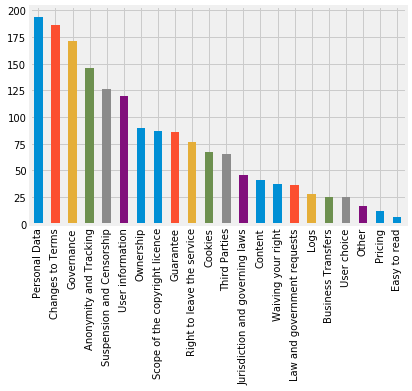

In [346]:
pd.value_counts(data['topics']).plot.bar()

In [347]:
#group small counts into 'Other', or drop accordingly

# data.topics.replace('Easy to read', 'Other', inplace=True)
# data.topics.replace('Pricing','Other', inplace=True)

In [348]:
#drop topics with low data counts
data = data[data.topics != 'Other']
data = data[data.topics != 'Pricing']
data = data[data.topics != 'Easy to read']

In [349]:
#clean the quote text
data['quoteText'] = data['quoteText'].str.replace(r"\n", " ")
data['quoteText'] = data['quoteText'].str.replace(r"\t", " ")
data['quoteText'] = data['quoteText'].str.replace(r"/", " ")
data['quoteText'] = data['quoteText'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
data['quoteText'] = data['quoteText'].str.replace(r"<strong>", " ")

In [350]:
data.quoteText.head()

0    We may suspend the Services or terminate the A...
1    Either party may terminate the Agreement (i) s...
2    We may terminate or restrict your use of our s...
3    Valve may cancel your Account or any particula...
4    General discussion and respectful debate with ...
Name: quoteText, dtype: object

## Explore the dataset

In [351]:
from sklearn.feature_extraction.text import CountVectorizer

In [352]:
cvec = CountVectorizer()
cvec.fit(data.quoteText)
len(cvec.get_feature_names())

4902

In [353]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(data.quoteText)
len(cvec.get_feature_names())

4649

In [354]:
# explore the top words in the quote text
cvec_mat = cvec.transform(data.quoteText)
words = cvec.get_feature_names()
a = cvec_mat.sum(axis=0)
word_df = pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False)
word_df.rename(columns={0: 'frequency'}, inplace=True)

In [355]:
word_df.head(10)

,frequency
information,1237
use,1075
services,788
content,638
service,625
terms,512
data,502
account,477
time,412
personal,395


There are similar words in the word database (eg. 'services' and 'service'. Lemmatization should fix this.

In [356]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['quoteText'].apply(tokenizer.tokenize)
# created a tokens column for future use

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# apply lemmatizer to each cell and return as string for use with Count Vectorizer and other methods
def lemmatize_block(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return " ".join(lemma_words)

data['lemmatized'] = data.tokens.apply(lemmatize_block)

In [357]:
data[['quoteText','lemmatized']].sample(8)

,quoteText,lemmatized
533,"all information, data, text, software, music, ...",all information data text software music sound...
1109,"Title and name To create a hotel, flight or...",title and name to create a hotel flight or oth...
53,Open Book Publishers will not send you email t...,open book publisher will not send you email th...
368,We may update these Terms from time to time y...,we may update these term from time to time you...
363,"We may change our Service and policies, and we...",we may change our service and policy and we ma...
1524,"As you use the Services, our servers may autom...",a you use the service our server may automatic...
103,"""We can change these terms at any time and we ...",we can change these term at any time and we wi...
1020,You give us permission to use your name and p...,you give u permission to use your name and pro...


In [358]:
all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))
np.mean(sentence_lengths)

107340 words total, with a vocabulary size of 6469
Max sentence length is 1410


64.93647912885662

In [359]:
cvec_lem = CountVectorizer(stop_words = 'english')
cvec_lem.fit(data.lemmatized)
len(cvec_lem.get_feature_names())

4105

In [360]:
cvec_lem_mat = cvec_lem.transform(data.lemmatized)

In [361]:
lem_words = cvec_lem.get_feature_names()
a = cvec_lem_mat.sum(axis=0)
lem_word_df = pd.DataFrame(a,columns=lem_words).transpose().sort_values(by=0,ascending=False)
lem_word_df.rename(columns={0: 'frequency'}, inplace=True)

In [362]:
lem_word_df.head(10)

,frequency
service,1413
information,1237
use,1075
content,659
term,530
account,525
user,512
data,502
party,497
right,493


Lemmatization has enabled grouping of similar words. It is a relatively conservative approach but proved more useful than stemming (not shown here) in repeated analysis.

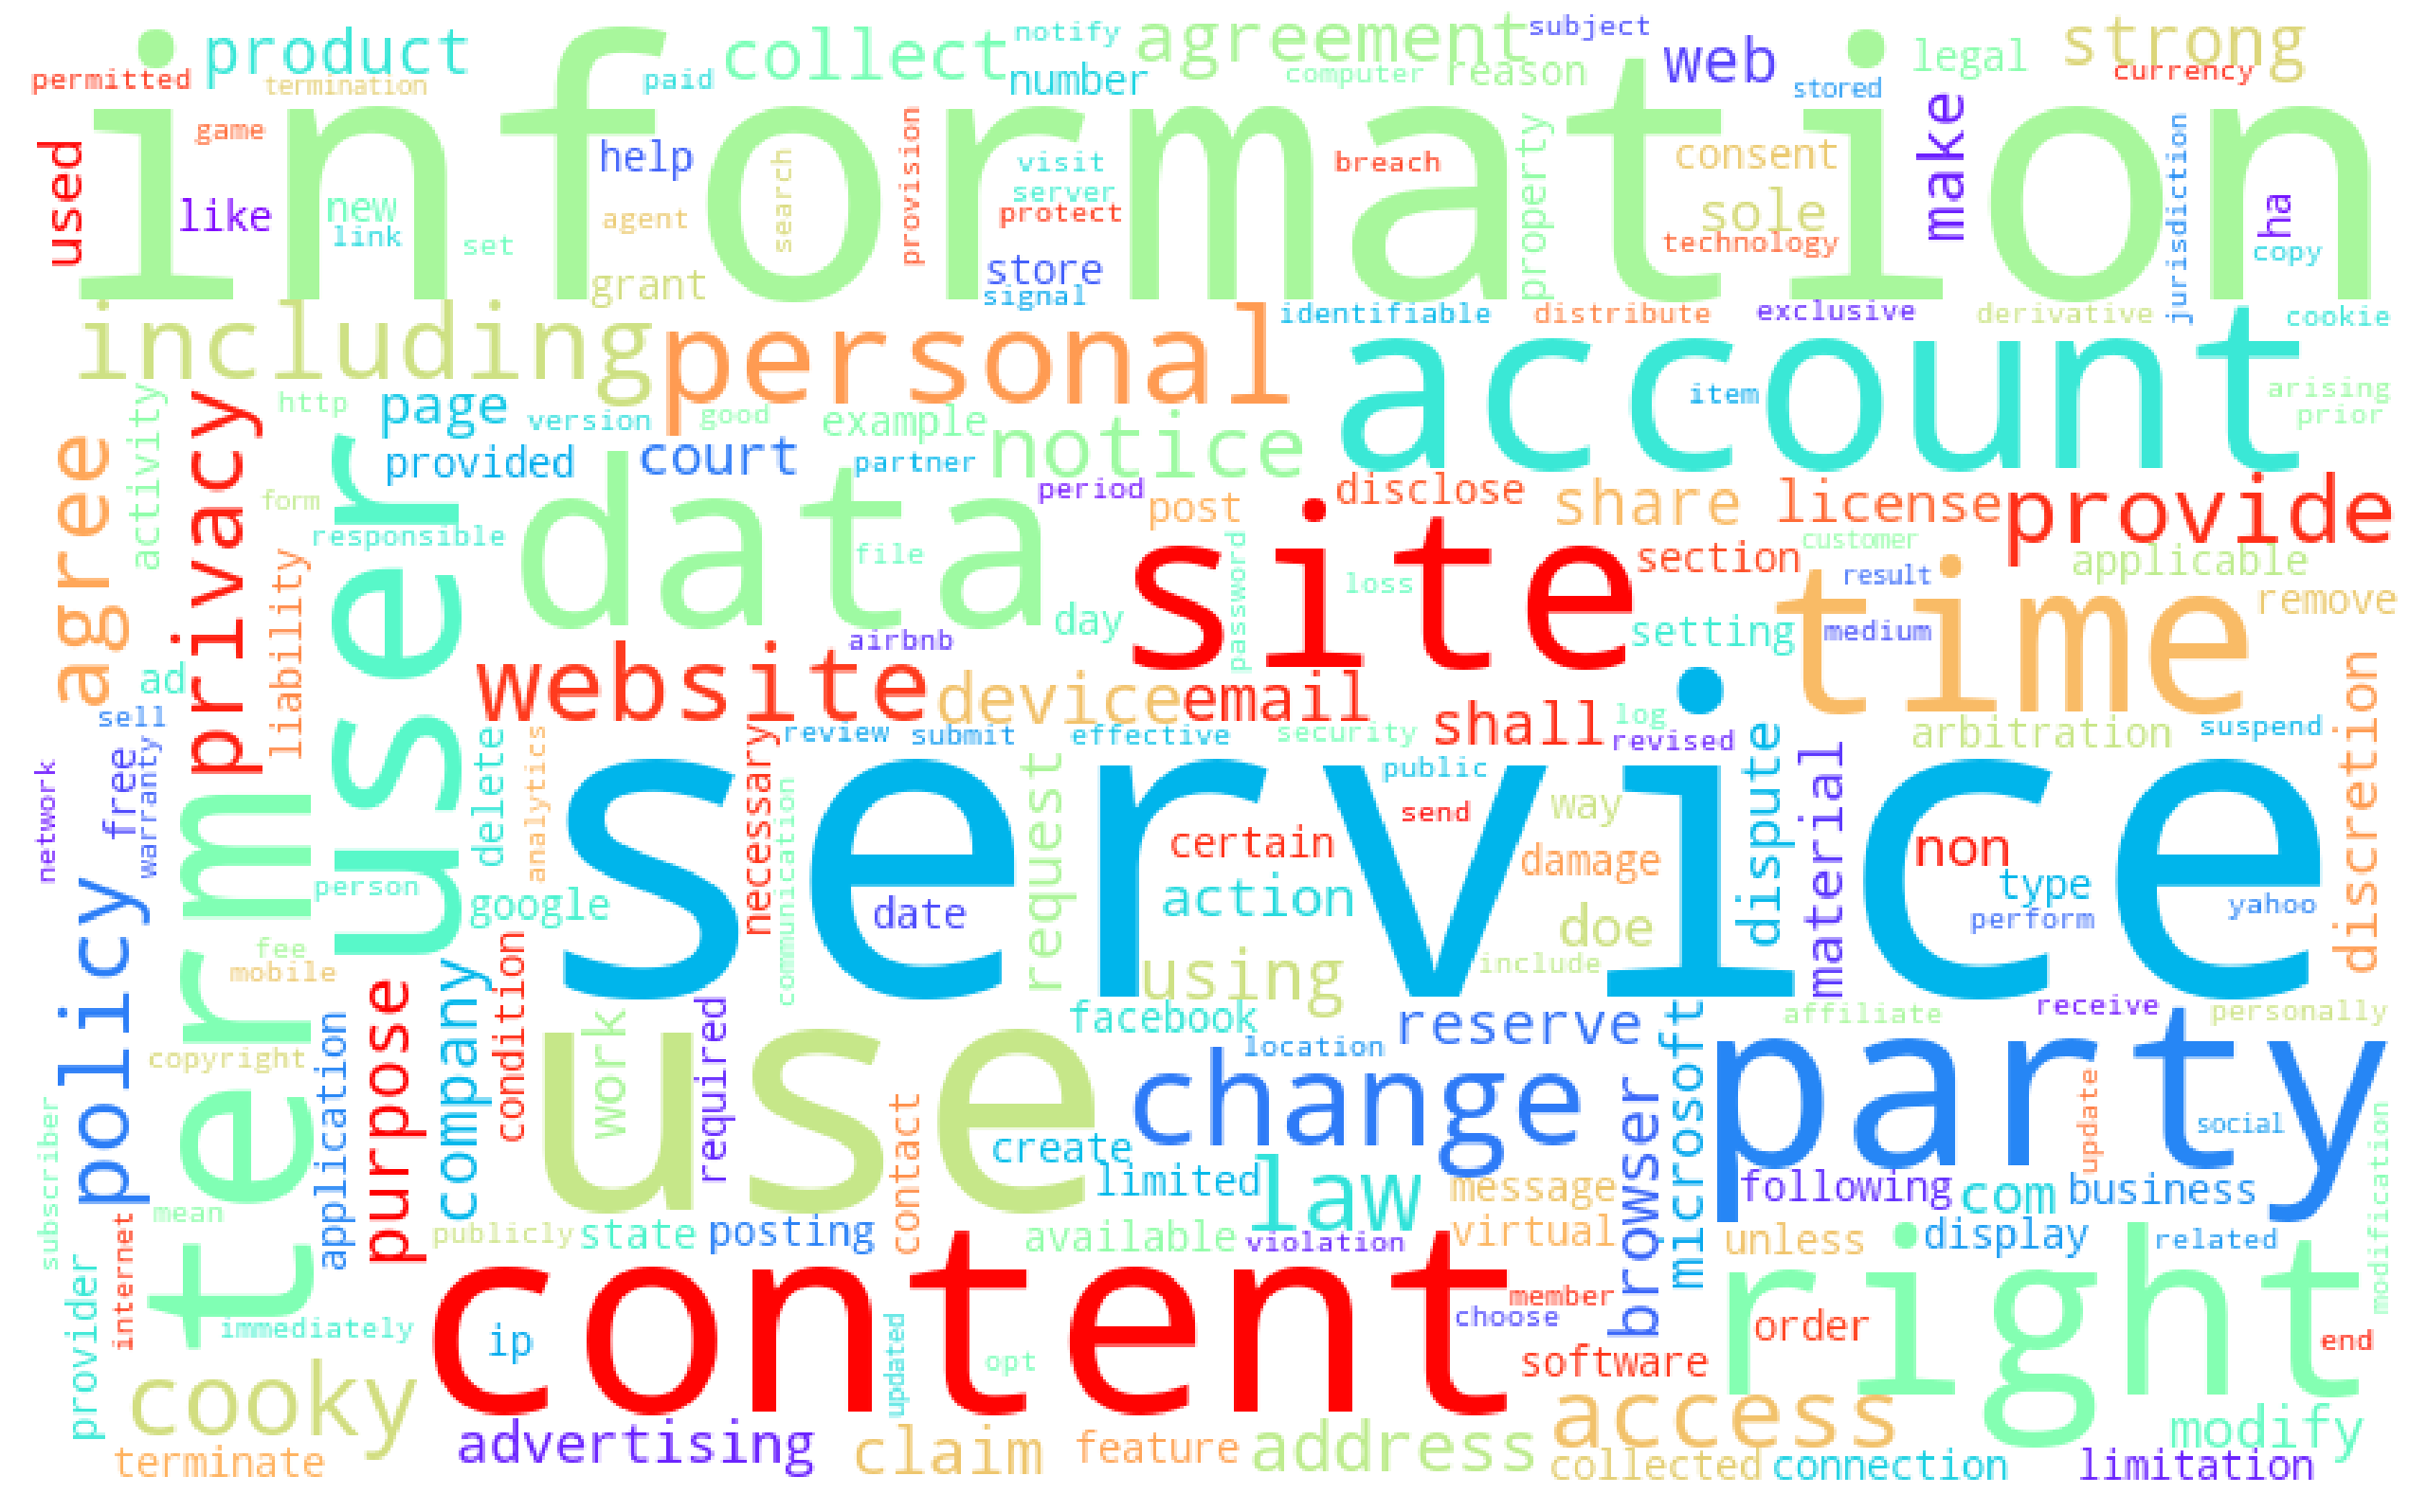

In [363]:
# visualize as a wordcloud
from wordcloud import WordCloud

wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2, width = 800, height = 500)

wc_gen = wc.generate_from_frequencies(dict(lem_word_df['frequency']))

plt.figure(figsize=(40,30))
plt.imshow(wc_gen)
plt.axis("off");

In [364]:
#the code below allows custom stopwords to be removed

from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['information','service','use','content','term',
                                            'right','time','party','change','account','user',
                                            'site','personal','data','website','collect','personal',
                                           'access','notice','including','policy','provide','privacy'])

Word Clouds can help visualize key words in documents, as seen above. However, Word Clouds by topic are difficult for obtaining meaning due to the large overlap between words in different topics, even with common stop words removed, as above.

This indicates that the documents/observations are largely similar, which means a model search should seek to identify less common words as predictors. TFIDF would be a good approach.

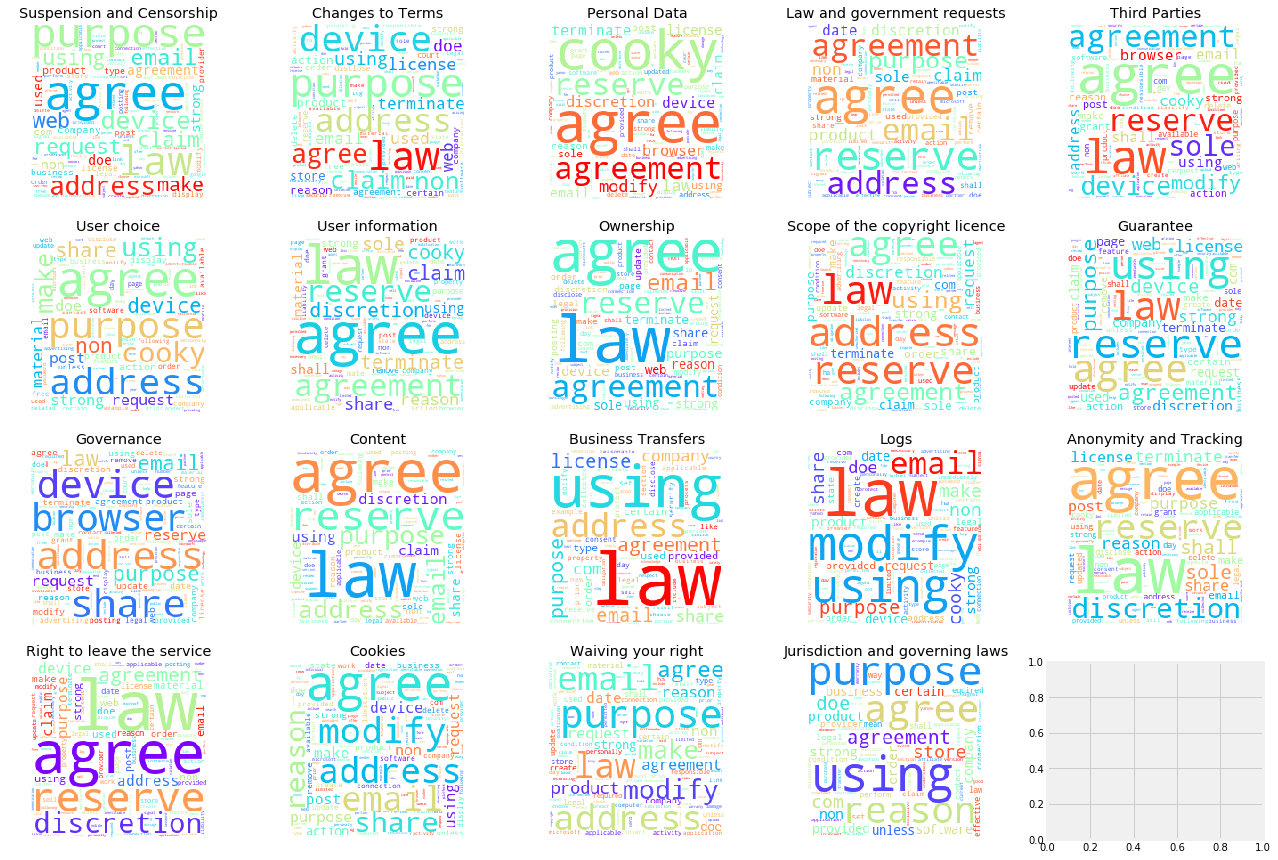

In [365]:
# word cloud for each topic (outcome variable)
topics = list(data.topics.unique())
wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2, width=200, height=200)
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,15))
for ax, topic in zip(axs.flat, topics):
    subset = data[data.topics == topic]
    cvec_top = TfidfVectorizer(stop_words=stop_words)
    cvec_top.fit(subset.lemmatized)
    cvec_top_mat = cvec_top.transform(data.lemmatized)
    topic_words = cvec_top.get_feature_names()
    a = cvec_top_mat.sum(axis=0)
    top_word_df = pd.DataFrame(a,columns=topic_words).transpose().sort_values(by=0,ascending=False)
    wc_top = wc.generate_from_frequencies(dict(top_word_df[0]))
    ax.imshow(wc_top)
    ax.set_title(str(topic))
    ax.axis("off")

## Modelling

The train-test split below is used throughout.

In [366]:
X = data[['lemmatized']]
y = data['topics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [367]:
y_train_topic = y_train

In [368]:
#verify y is stratified
y_test.value_counts()

Personal Data                      58
Changes to Terms                   56
Governance                         51
Anonymity and Tracking             44
Suspension and Censorship          38
User information                   36
Ownership                          27
Scope of the copyright licence     26
Guarantee                          26
Right to leave the service         23
Cookies                            20
Third Parties                      20
Jurisdiction and governing laws    14
Content                            12
Waiving your right                 11
Law and government requests        11
User choice                         8
Logs                                8
Business Transfers                  7
Name: topics, dtype: int64

In [369]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train['lemmatized'])
X_train_counts = cv.transform(X_train['lemmatized'])
X_test_counts = cv.transform(X_test['lemmatized'])

In [370]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr.fit(X_train_counts, y_train)

lr.score(X_train_counts, y_train)

0.9948141745894555

Due to the nature of the dataset, a high score is obtained on the train set: overfitting is common in NLP and difficult to address.

The initial test score is of greater importance:

In [371]:
lr.score(X_test_counts, y_test)

0.6149193548387096

In [372]:
# obtain predicted topics
y_train_preds = lr.predict(X_train_counts)
y_test_preds = lr.predict(X_test_counts)

In [373]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def scores(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = scores(y_test, y_test_preds)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.615, precision = 0.621, recall = 0.615, f1 = 0.614


These are promising scores compared to the baseline:

In [374]:
baseline = y_test.value_counts().max() / len(y_test)
print(baseline)

0.11693548387096774


In [375]:
from sklearn.metrics import confusion_matrix, classification_report

def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [376]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

The confusion matrices below show how the model performed at classifying test data into the 19 topics.

In [377]:
print(confusion_matrix(y_test, y_test_preds))

[[25  0  0  0  4  1  2  0  1  0  0  5  0  0  0  0  0  6  0]
 [ 0  5  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 52  0  0  2  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 1  0  0  1  0  1  0  0  0  0  3  2  0  0  0  0  0  4  0]
 [ 6  0  0  0 10  0  0  0  0  0  0  2  0  0  0  1  0  1  0]
 [ 1  0  1  0  0 30  3  1  0  1  2  4  1  2  4  0  0  0  1]
 [ 1  0  0  1  0  4 17  0  0  0  1  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 12  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  8  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  2  0  0  0  0  0  2  0]
 [ 1  0  0  0  0  0  2  0  0  0 14  2  3  3  0  0  0  2  0]
 [ 5  0  0  1  0  3  0  0  4  3  1 32  0  0  1  3  0  5  0]
 [ 0  0  0  2  0  2  2  0  0  0  1  0 13  0  2  0  0  1  0]
 [ 0  0  0  0  0  3  0  0  0  0  2  0  1 19  0  0  0  1  0]
 [ 0  0  0  0  0  2  3  0  0  0  1  1  1  0 30  0  0  0  0]
 [ 2  0  0  1  1  0  0  0  0  0  1  7  0  0  0  7  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1

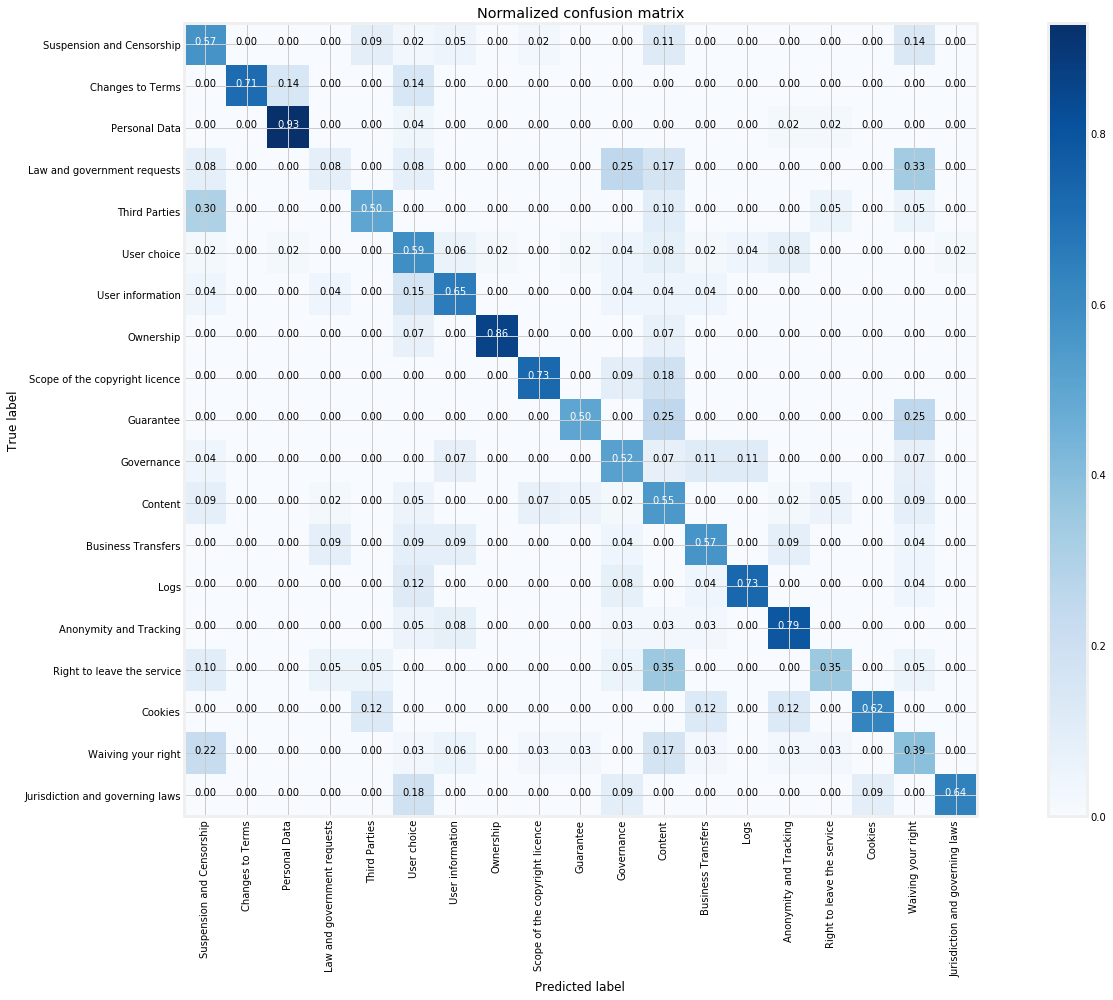

In [378]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(20,14))
plot_confusion_matrix(cnf_matrix, classes=topics, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The first model makes good overall predictions with some clear misses (eg. Law & gov't requests)

For potential improvement on the bag of words model, TFIDF should account better for common words across documents.

In [379]:
# try TFIDF as alternative
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train['lemmatized'])
X_train_tfidf = tfidf.transform(X_train['lemmatized'])
X_test_tfidf = tfidf.transform(X_test['lemmatized'])

In [380]:
lr_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf = lr_tfidf.predict(X_test_tfidf)

In [381]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.635, precision = 0.639, recall = 0.635, f1 = 0.633


TFIDF is a small but clear improvement on the Bag of Words(0.635 vs 0.615)

In [382]:
lr_tfidf = LogisticRegression(C=1, class_weight='balanced', solver='liblinear', 
                         multi_class='auto', random_state=40)
lr_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf = lr_tfidf.predict(X_test_tfidf)

In [383]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.643, precision = 0.643, recall = 0.643, f1 = 0.636


Our dataset has some imbalance issues, so this can be addressed by oversampling.

In [384]:
from imblearn.over_sampling import RandomOverSampler

In [385]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X_train_tfidf, y_train)

print(pd.Series(y_resampled).value_counts())

Scope of the copyright licence     136
Third Parties                      136
Content                            136
Ownership                          136
Changes to Terms                   136
Law and government requests        136
Jurisdiction and governing laws    136
Waiving your right                 136
Cookies                            136
Suspension and Censorship          136
Governance                         136
Right to leave the service         136
User choice                        136
User information                   136
Business Transfers                 136
Guarantee                          136
Logs                               136
Personal Data                      136
Anonymity and Tracking             136
dtype: int64


In [386]:
lr_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr_tfidf.fit(X_resampled, y_resampled)

y_preds_oversampled = lr_tfidf.predict(X_test_tfidf)

In [387]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.644, recall = 0.641, f1 = 0.638


Resampling resulted in a very minor improvement in scores

Refine Logistic Regression model further using GridSearch

In [388]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [389]:
def fitter(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print(model.score(X_train, y_train))
    print(model.score(X_test, y_test))
    print()
    print(classification_report(y_train, model.predict(X_train)))
    print()
    print(classification_report(y_test, model.predict(X_test)))

In [390]:
lr_tfidf_gs = LogisticRegression()
model_params = {'penalty':['l2'],
             'C':np.logspace(-2,2,5),
             'class_weight':['balanced',None],
             'solver':['newton-cg','lbfgs'],
             'multi_class':['multinomial'],
             'max_iter':[1000]
            }
gs = GridSearchCV(lr_tfidf_gs, model_params, cv=5, iid=False)    
fitter(gs, X_resampled, y_resampled, X_test_tfidf, y_test)

0.9953560371517027
0.6411290322580645

                                 precision    recall  f1-score   support

         Anonymity and Tracking       0.99      0.99      0.99       136
             Business Transfers       1.00      1.00      1.00       136
               Changes to Terms       1.00      1.00      1.00       136
                        Content       1.00      1.00      1.00       136
                        Cookies       0.99      1.00      0.99       136
                     Governance       1.00      1.00      1.00       136
                      Guarantee       1.00      1.00      1.00       136
Jurisdiction and governing laws       1.00      1.00      1.00       136
    Law and government requests       1.00      1.00      1.00       136
                           Logs       0.96      1.00      0.98       136
                      Ownership       1.00      0.99      0.99       136
                  Personal Data       1.00      0.98      0.99       136
     Right 

In [391]:
gs.best_params_

{'C': 100.0,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [392]:
gs.best_score_

0.915135059871902

In [393]:
lr_tfidf = LogisticRegression(C=100.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial',
                          random_state=7)
lr_tfidf.fit(X_resampled, y_resampled)

y_preds_oversampled = lr_tfidf.predict(X_test_tfidf)

In [394]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.642, recall = 0.641, f1 = 0.638


This is the best-performing model obtained: GridSearch did not identify considerably better hyperparameters. Its performance is highly variable by topic as seen in the confusion matrix below, which likely is an indicator of the quality and differentiation of the topics. Some still perform poorly despite the tuning.

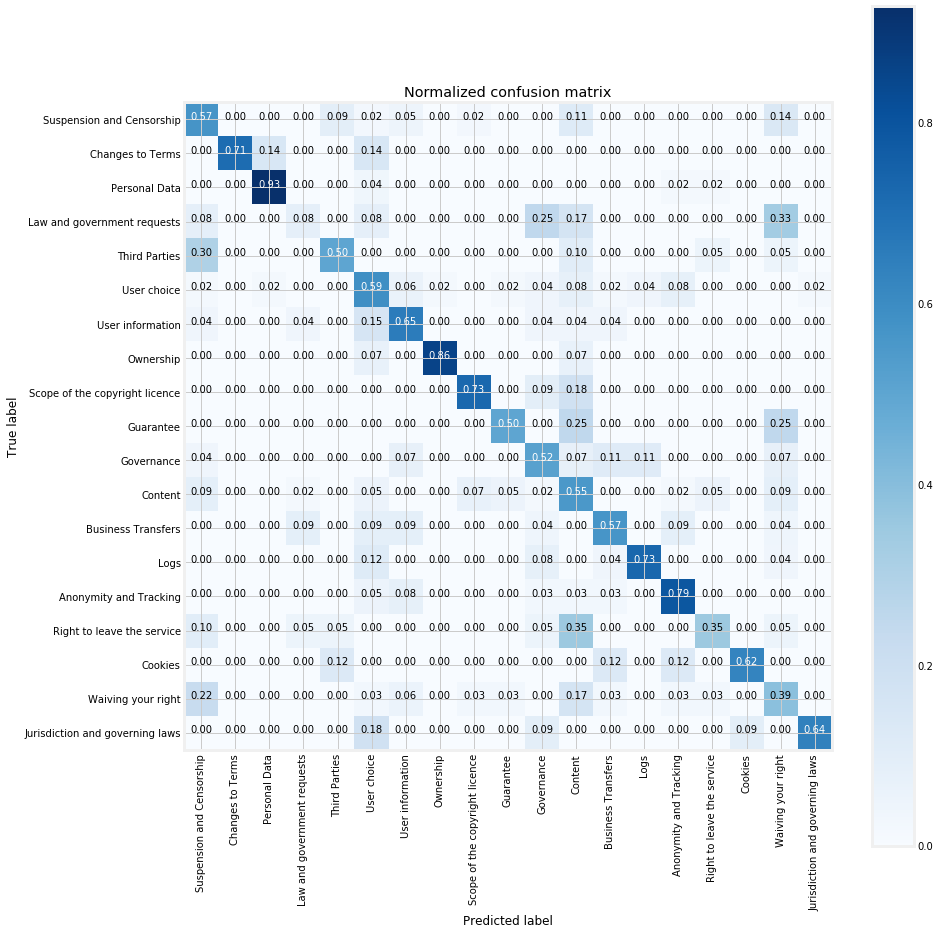

In [395]:
# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, y_preds_oversampled)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(cnf_matrix, classes=topics, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [396]:
residual_cnf = cnf_matrix2 - cnf_matrix

Confusion matrix, without normalization
[[ 2  0  0  0 -1  1 -1  0 -1  1  0  1  0  0  0  0  0 -2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 -2  0  0  0  1  0  0  0  0]
 [-2  0  0  1  2  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
 [-1  0 -1  0  0  5  0 -1  0 -1 -1 -2  0  2 -1  0  0  0  1]
 [ 0  0  0 -1  0  0  0  0  0  0  1 -1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0 -1  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0 -1  0  0  0  0  1  0 -2  0]
 [ 0  0  0  0  0  1  0  0  0 -1  0  1  1  0  0 -1  0 -1  0]
 [ 1  0  0  0  0  1 -2  0  0  0  0  1 -2  1 -1  1  0  0  0]
 [ 0  0  0  0  0 -2  0  0  0  0  0  1  0  2  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1  1  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  1 -1  0  0  0  1  0  0  0]


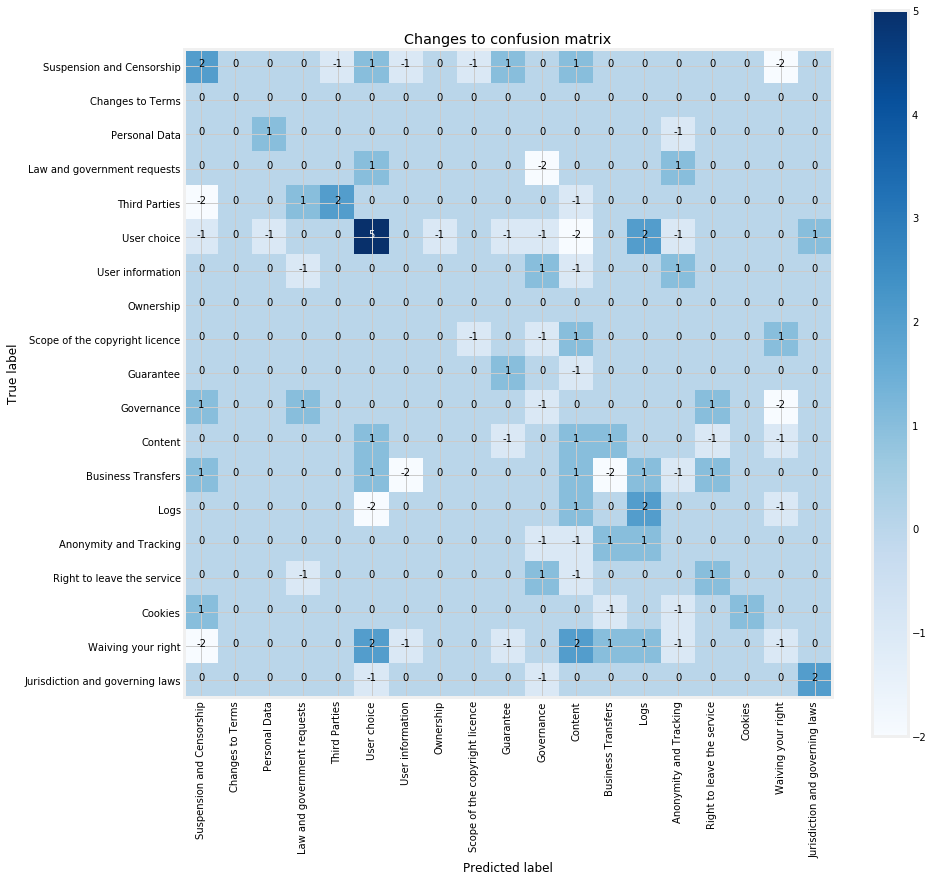

In [397]:
plt.figure(figsize=(14,13))
plot_confusion_matrix(residual_cnf, classes=topics, normalize=False,
                      title='Changes to confusion matrix')

plt.show()

In [398]:
# save the incorrect predictions for review later
conf_dict1 = {}
conf_dict1['true_topic'] = y_test
conf_dict1['pred_topic'] = y_preds_tfidf

## Beyond Logistic Regression
To compare, additional classification models are tested for their performance. Any showing comparable scores to logistic regression were further tuned using GridSearch (not shown here in full) and their best parameters inserted into the models below.

In [399]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid

In [400]:
models = [LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=7),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          SVC(gamma='auto'),
          RandomForestClassifier(n_estimators=100,
                                max_depth=1000,
                                class_weight='balanced'),
          ExtraTreesClassifier(n_estimators=100),
          MLPClassifier(solver='lbfgs', 
                    alpha=10**(-1), 
                    activation='identity', 
                    random_state=1,
                    batch_size='auto',
                       ),
          RidgeClassifier(alpha= 1.0,
                         class_weight= 'balanced',
                         normalize= True,
                         solver= 'sag',
                        tol=1e-2),
          Perceptron(max_iter=1000,tol=1e-3),
          PassiveAggressiveClassifier(max_iter=1000,tol=1e-3,
                                     C=10, class_weight='balanced',
                                     loss='squared_hinge'),
          SGDClassifier(alpha=.0001, loss='log',
                                       penalty="l2",
                                       max_iter=1000,
                                       tol=1e-3),
          MultinomialNB(alpha=.01, fit_prior=False),
          BernoulliNB(alpha=.01),
          LinearSVC(penalty="l2", C=0.1)]

In [401]:
model_dict = {}
for model in models:
    model.fit(X_resampled, y_resampled)
    y_preds_oversampled = model.predict(X_test_tfidf)
    accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
    model_dict[str(model).split('(')[0]] = [accuracy, precision, recall, f1]
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=7, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.641, precision = 0.644, recall = 0.641, f1 = 0.638

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
accuracy = 0.550, precision = 0.588, recall = 0.550, f1 = 0.547

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.456, precision = 0.469, recall = 0.456, f1 = 0.456



In [402]:
importances_sum = pd.DataFrame.from_dict(model_dict)
model_compare = importances_sum.T
model_compare.set_axis(['accuracy','precision','recall','f1'], axis=1, inplace=True)
model_compare = model_compare.sort_values('accuracy', ascending=False)

In [403]:
from matplotlib.ticker import PercentFormatter

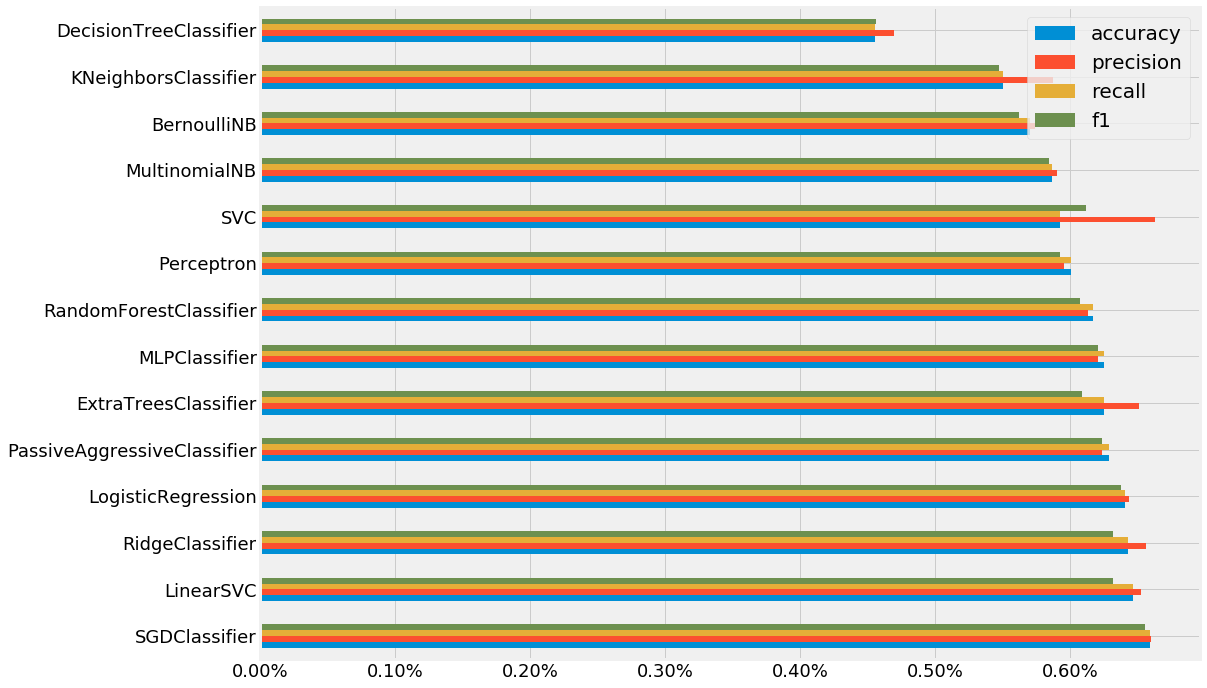

In [404]:
fig, ax = plt.subplots(figsize=(15, 12))
model_compare.plot(kind='barh', ax=ax, fontsize=18)
ax.set_xlim
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend(fontsize=20)
plt.show()

It can be seen above that Logistic Regression is slightly outperformed by two other classification models

## Alternative Models

Word2Vec / WordNet can potentially classify more intelligently than basic lemmatization/stemming.

In [405]:
import gensim

word2vec_path = "part-03/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [406]:
def  get_average_word2vec (tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [407]:
list_labels = list(y)

In [408]:
embeddings  = get_word2vec_embeddings(word2vec, data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.3, random_state=7)

In [409]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [410]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = scores(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.609, precision = 0.641, recall = 0.609, f1 = 0.615


In [411]:
sampler = RandomOverSampler(random_state=1)
X_resampled_w2v, y_resampled_w2v = sampler.fit_sample(X_train_word2vec, y_train_word2vec)

In [412]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_resampled_w2v, y_resampled_w2v)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = scores(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.613, precision = 0.642, recall = 0.613, f1 = 0.618


In [413]:
w2v_gs = LogisticRegression()
model_params = {'penalty':['l2'],
             'C':np.logspace(-2,2,5),
             'class_weight':['balanced',None],
             'solver':['newton-cg','lbfgs'],
             'multi_class':['multinomial'],
             'max_iter':[1000]
            }
gs = GridSearchCV(w2v_gs, model_params, cv=5, iid=False)    
fitter(gs, X_resampled_w2v, y_resampled_w2v, X_test_word2vec, y_test_word2vec)

0.9858886346300534
0.6169354838709677

                                 precision    recall  f1-score   support

         Anonymity and Tracking       1.00      0.97      0.99       138
             Business Transfers       1.00      1.00      1.00       138
               Changes to Terms       1.00      1.00      1.00       138
                        Content       1.00      1.00      1.00       138
                        Cookies       0.96      1.00      0.98       138
                     Governance       0.99      0.96      0.97       138
                      Guarantee       0.99      1.00      1.00       138
Jurisdiction and governing laws       1.00      1.00      1.00       138
    Law and government requests       0.99      1.00      1.00       138
                           Logs       0.98      1.00      0.99       138
                      Ownership       1.00      0.97      0.99       138
                  Personal Data       0.95      0.91      0.93       138
     Right 

Confusion matrix, without normalization
[[ 1  0  0  0  3 -1 -2  0 -1  2  0  2  0  0  0  4  1  5  0]
 [ 0  1 -1  0  0 -1  0  0  1  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  1  0]
 [-1  0  0  6  0  0  0  0  0  0  0 -1  1  0  0  0  0 -4  0]
 [-3  0  0  1  3  0  0  0  0  0  0 -2  0  0  0  1  1 -1  0]
 [-1  0  2  2  0 -6 -1 -1  0 -1  0  1  1  0 -3  0  0  0  0]
 [-1  0  0 -1  0 -2 -4  0  1  0  0  1  1  0  2  1  0  1  0]
 [ 0  0  0  0  0 -1  0 -3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0 -1 -2  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 -2  1  0  0  1  0 -1  0]
 [-1  0  0  1  0  2 -1  0  0  0 -1  0 -3  1  0  0  0 -1  0]
 [-2  0  0  1  0  0  0  0 -1 -1  0 -1  1  0  0  0  0  1  0]
 [ 0  0  0 -2  0 -2 -2  0  0  0  1  2 -2  0  0  0  0  1  0]
 [ 0  0  0  0  0 -1  0  0  0  0  4  0 -1 -1  0  0  0 -1  1]
 [ 0  1  0  2  0 -1 -2  0  0  0  1 -1 -1  0 -4  0  1  0  0]
 [-2  0  0 -1  0  0  0  0  2  0  0 -3  0  0  0  4  0  1  0]


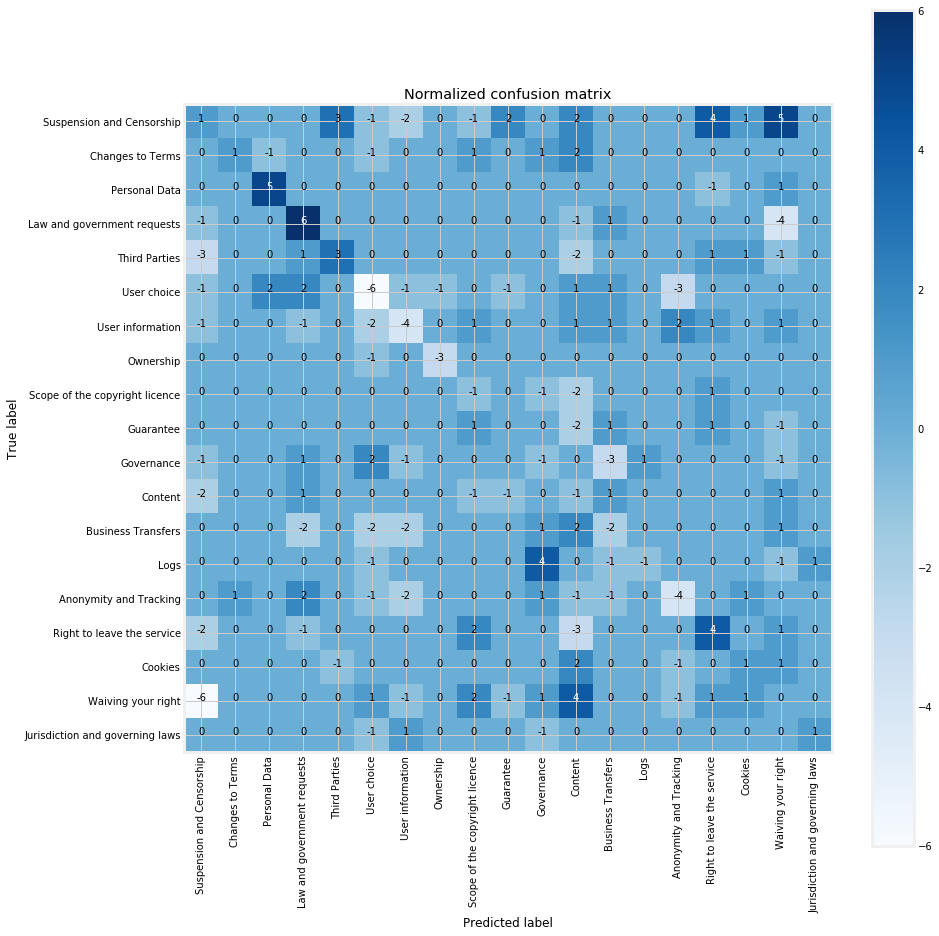

In [414]:
# Compute confusion matrix
cnf_matrix3 = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
np.set_printoptions(precision=2)
residual_conf2 = cnf_matrix3 - cnf_matrix

# Plot normalized confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(residual_conf2, classes=topics, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

Unfortunately, on this occasion, Word2Vec performs slightly more poorly than earlier models, despite the relatively high precision.

## Principle Component Analysis

In [415]:
from  sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

lsa = TruncatedSVD(n_components=10)
lsa.fit(X_train_counts, y_train)
lsa_scores = lsa.transform(X_test_counts)

In [416]:
for i, pc in enumerate(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']):
    print(pc, 'weighting vector:\n', lsa.components_[i])
    print('-------------------------------------\n')

PC1 weighting vector:
 [8.36e-04 1.16e-03 1.13e-04 ... 4.67e-05 3.08e-04 1.90e-04]
-------------------------------------

PC2 weighting vector:
 [-2.13e-03 -8.92e-03 -2.28e-04 ...  4.59e-05 -2.31e-04  1.03e-04]
-------------------------------------

PC3 weighting vector:
 [ 2.40e-05  1.94e-02 -1.13e-04 ... -4.50e-05 -2.16e-04 -1.59e-04]
-------------------------------------

PC4 weighting vector:
 [-0.  0. -0. ...  0.  0.  0.]
-------------------------------------

PC5 weighting vector:
 [-1.11e-03 -3.01e-04 -1.59e-04 ...  1.26e-05  4.87e-05  1.46e-04]
-------------------------------------

PC6 weighting vector:
 [ 0. -0. -0. ... -0. -0. -0.]
-------------------------------------

PC7 weighting vector:
 [ 2.69e-03  3.72e-03 -5.46e-05 ...  4.97e-05 -2.60e-04 -1.89e-04]
-------------------------------------

PC8 weighting vector:
 [ 3.68e-04 -2.55e-03 -1.99e-04 ...  3.53e-05  2.67e-04 -2.41e-04]
-------------------------------------

PC9 weighting vector:
 [-1.13e-03  1.12e-03  4.63e-05 

In [417]:
exp_var_eigenvals = lsa.explained_variance_
exp_var_pct = lsa.explained_variance_ratio_

print('eigenvalues:\n', exp_var_eigenvals, '\n')
print('explained variance pct:\n', exp_var_pct)

eigenvalues:
 [8.37 3.56 2.98 2.66 1.7  1.68 1.51 1.47 1.21 1.17] 

explained variance pct:
 [0.12 0.05 0.04 0.04 0.02 0.02 0.02 0.02 0.02 0.02]


Explanatory value of PCA is relatively low for this dataset: difficult to condense to a small number of principle components.

## Unsupervised Learning

In [418]:
def lemmatize_block_keep_tokens(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return lemma_words

data['lemmatized_tokens'] = data.tokens.apply(lemmatize_block_keep_tokens)

In [419]:
dictionary = gensim.corpora.Dictionary(data['lemmatized_tokens'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 a
1 agreement
2 are
3 attendee
4 cause
5 harm
6 if
7 in
8 is
9 likely
10 manner


In [420]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data['lemmatized_tokens']]

In [421]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=19, id2word=dictionary, passes=2, workers=2)

In [422]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.035*"your" + 0.033*"you" + 0.032*"to" + 0.029*"the" + 0.026*"account" + 0.021*"of" + 0.021*"a" + 0.020*"and" + 0.018*"our" + 0.016*"information"
Topic: 1 
Words: 0.045*"and" + 0.034*"you" + 0.030*"to" + 0.026*"the" + 0.023*"your" + 0.023*"or" + 0.022*"of" + 0.017*"any" + 0.016*"a" + 0.015*"information"
Topic: 2 
Words: 0.046*"the" + 0.037*"or" + 0.036*"to" + 0.028*"and" + 0.025*"in" + 0.022*"of" + 0.019*"a" + 0.016*"you" + 0.013*"any" + 0.012*"your"
Topic: 3 
Words: 0.028*"to" + 0.026*"and" + 0.024*"the" + 0.015*"you" + 0.012*"in" + 0.010*"on" + 0.010*"our" + 0.009*"by" + 0.009*"be" + 0.009*"your"
Topic: 4 
Words: 0.050*"to" + 0.036*"or" + 0.028*"service" + 0.027*"the" + 0.026*"and" + 0.019*"a" + 0.019*"you" + 0.017*"your" + 0.015*"information" + 0.015*"party"
Topic: 5 
Words: 0.057*"to" + 0.033*"you" + 0.026*"and" + 0.022*"the" + 0.020*"or" + 0.019*"we" + 0.018*"any" + 0.015*"your" + 0.013*"our" + 0.012*"for"
Topic: 6 
Words: 0.035*"to" + 0.030*"or" + 0.029*"we" + 0

In [423]:
from gensim import corpora, models
tfidf_gensim = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_gensim[bow_corpus]

In [424]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=19, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: ', idx)
    print('Words: ', topic)
    print()

Topic:  0
Words:  0.006*"last" + 0.005*"updated" + 0.004*"content" + 0.004*"your" + 0.004*"our" + 0.004*"you" + 0.004*"we" + 0.003*"of" + 0.003*"and" + 0.003*"use"

Topic:  1
Words:  0.005*"or" + 0.005*"any" + 0.004*"this" + 0.004*"of" + 0.004*"the" + 0.004*"is" + 0.004*"our" + 0.004*"service" + 0.004*"in" + 0.004*"we"

Topic:  2
Words:  0.005*"content" + 0.005*"third" + 0.005*"party" + 0.004*"we" + 0.004*"information" + 0.004*"user" + 0.004*"or" + 0.004*"do" + 0.004*"is" + 0.004*"cooky"

Topic:  3
Words:  0.005*"we" + 0.005*"information" + 0.004*"share" + 0.004*"data" + 0.004*"your" + 0.004*"personal" + 0.004*"with" + 0.003*"not" + 0.003*"website" + 0.003*"this"

Topic:  4
Words:  0.006*"any" + 0.006*"change" + 0.006*"time" + 0.006*"term" + 0.006*"or" + 0.006*"at" + 0.005*"notice" + 0.005*"content" + 0.004*"be" + 0.004*"these"

Topic:  5
Words:  0.006*"content" + 0.005*"or" + 0.005*"we" + 0.005*"you" + 0.004*"any" + 0.004*"your" + 0.004*"user" + 0.004*"uploaded" + 0.004*"may" + 0.004*

In [425]:
lda_model_tfidf.get_topics()

array([[3.24e-03, 1.15e-03, 1.60e-03, ..., 9.08e-05, 9.08e-05, 9.08e-05],
       [3.36e-03, 1.30e-03, 2.69e-03, ..., 7.92e-05, 7.92e-05, 7.92e-05],
       [3.51e-03, 5.77e-04, 2.33e-03, ..., 8.00e-05, 8.00e-05, 8.00e-05],
       ...,
       [2.78e-03, 2.78e-03, 1.12e-03, ..., 8.85e-05, 8.85e-05, 8.85e-05],
       [2.26e-03, 1.60e-03, 3.30e-03, ..., 1.01e-04, 1.01e-04, 1.01e-04],
       [4.28e-03, 2.88e-03, 1.51e-03, ..., 7.49e-05, 7.49e-05, 3.83e-04]],
      dtype=float32)

In [426]:
list(lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability = 0.5))

[[(17, 0.8065628)],
 [(14, 0.5044952)],
 [(10, 0.79672414)],
 [(4, 0.56675255)],
 [(7, 0.8627372)],
 [(3, 0.56359375)],
 [(11, 0.8247324)],
 [(17, 0.8253041)],
 [],
 [],
 [(0, 0.78733736)],
 [(13, 0.6899761)],
 [(16, 0.8153425)],
 [(12, 0.8226769)],
 [],
 [(8, 0.8321081)],
 [(12, 0.777956)],
 [(6, 0.7979374)],
 [(13, 0.7481306)],
 [(8, 0.7881418)],
 [(3, 0.742918)],
 [(3, 0.73747975)],
 [(4, 0.60933316)],
 [(16, 0.80184823)],
 [(9, 0.80128413)],
 [(3, 0.8594386)],
 [(11, 0.78694)],
 [(16, 0.7705937)],
 [(6, 0.70765406)],
 [(9, 0.8301556)],
 [(9, 0.8301556)],
 [(2, 0.8260073)],
 [(8, 0.77182937)],
 [(6, 0.7294768)],
 [(3, 0.73480326)],
 [(11, 0.7736963)],
 [(8, 0.747503)],
 [(11, 0.7108833)],
 [],
 [(3, 0.8130674)],
 [(6, 0.81414217)],
 [(8, 0.7942393)],
 [(16, 0.7986966)],
 [(18, 0.73390937)],
 [(2, 0.79232526)],
 [(6, 0.8435701)],
 [(7, 0.83597845)],
 [(3, 0.8219952)],
 [(1, 0.5175793)],
 [],
 [(8, 0.7489438)],
 [(8, 0.7489438)],
 [(7, 0.8232909)],
 [(15, 0.85784286)],
 [(0, 0.8057704

In [427]:
unsup_topics = []
for i in (list(lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0.5))):
    if i == []:
        unsup_topics.append(None)
    else:
        for j in i:
            unsup_topics.append(j[0])

In [428]:
compare_class = pd.DataFrame(unsup_topics, columns=['unsup_class'])

In [429]:
compare_class['true'] = y

In [430]:
cf = pd.get_dummies(compare_class)

The plot below shows the association between unsupervised classes and the trained classes, to identify whether any groupings are made which correspond to known topics. Note that this changes on every run of the above code so it's likely the correlations will differ.


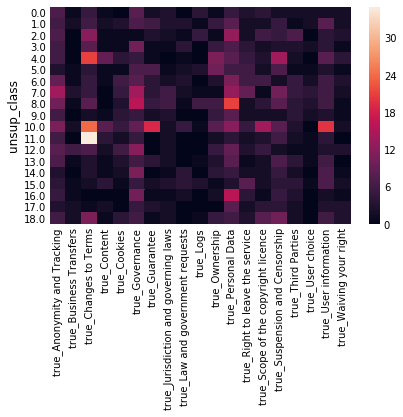

In [431]:
sns.heatmap(cf.groupby('unsup_class').sum())

In [432]:
compare_meaning = pd.DataFrame(unsup_topics, columns=['unsup_class'])
compare_meaning['true'] = data.case
cm = pd.get_dummies(compare_meaning)

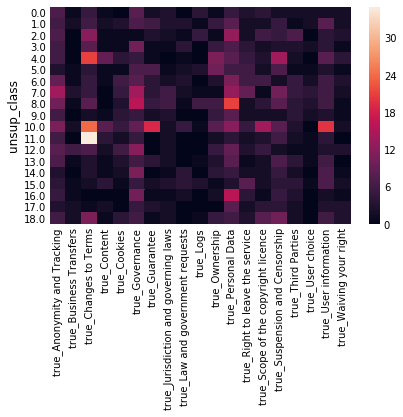

In [433]:
sns.heatmap(cf.groupby('unsup_class').sum())

## Good / Bad Classification

In [434]:
ratingdf = pd.read_csv('revised_points.csv', header = 'infer')

In [435]:
#select useful rows only
ratingdf = ratingdf[['id', 'needModeration','services', 'Source', 'quoteText', 'topics', 'case', 'point', 'score']]

In [436]:
ratingdf.point.isnull().sum()

133

In [437]:
ratingdf.dropna(subset=['point'], inplace=True)

In [438]:
ratingdf.point.value_counts()

bad        840
good       442
neutral    263
blocker      9
Good         1
Name: point, dtype: int64

In [439]:
ratingdf.point.replace('Bad', 'bad', inplace=True)
ratingdf.point.replace('blocker', 'bad', inplace=True)
ratingdf.point.replace('Good', 'good', inplace=True)

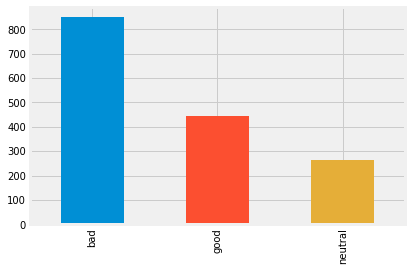

In [440]:
pd.value_counts(ratingdf['point']).plot.bar()

In [441]:
binarydf = ratingdf

In [442]:
#Use this option for binary bad/good
binarydf.point.replace('good', 'other', inplace=True)
binarydf.point.replace('neutral', 'other', inplace=True)
ratingdf = pd.get_dummies(binarydf, columns =['point'], drop_first=False)

In [443]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
ratingdf['tokens'] = ratingdf['quoteText'].apply(tokenizer.tokenize)
# created a tokens column for future use

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# apply lemmatizer to each cell and return as string for use with Count Vectorizer and other methods
def lemmatize_block(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return " ".join(lemma_words)

ratingdf['lemmatized'] = ratingdf.tokens.apply(lemmatize_block)

In [444]:
X = ratingdf[['lemmatized']]

#use for multiclass
# y = ratingdf['point']

#use for binary
y = ratingdf['point_other']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [445]:
tfidf_class = TfidfVectorizer(stop_words='english')
tfidf_class.fit(X_train_class['lemmatized'])
X_train_tfidf_class = tfidf_class.transform(X_train_class['lemmatized'])
X_test_tfidf_class = tfidf_class.transform(X_test_class['lemmatized'])

In [446]:
from sklearn.linear_model import LogisticRegression

In [447]:
models = [LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=40),
          KNeighborsClassifier(leaf_size =10, weights='distance', metric='euclidean', n_neighbors=5),
          DecisionTreeClassifier(),
          SVC(gamma='auto'),
          RandomForestClassifier(n_estimators=100,
                                max_depth=1000,
                                class_weight='balanced'),
          ExtraTreesClassifier(n_estimators=100),
          MLPClassifier(solver='lbfgs', 
                    alpha=10**(-1),
                    hidden_layer_sizes=1, 
                    activation='identity', 
                    random_state=1,
                    batch_size='auto',
                       ),
          RidgeClassifier(alpha= 1.0,
                         class_weight= 'balanced',
                         normalize= True,
                         solver= 'sag',
                        tol=1e-2),
          Perceptron(max_iter=1000,tol=1e-3),
          PassiveAggressiveClassifier(max_iter=1000,tol=1e-3,
                                     C=10, class_weight='balanced',
                                     loss='squared_hinge'),
          SGDClassifier(alpha=.0001, loss='log',
                                       penalty="l2",
                                       max_iter=1000,
                                       tol=1e-3),
          MultinomialNB(alpha=.01, fit_prior=False),
          BernoulliNB(alpha=.01),
          LinearSVC(penalty="l2", C=0.1)]

In [448]:
for model in models:
    model.fit(X_train_tfidf_class, y_train_class)
    y_preds = model.predict(X_test_tfidf_class)
    accuracy, precision, recall, f1 = scores(y_test_class, y_preds)
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.737, precision = 0.738, recall = 0.737, f1 = 0.737

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
accuracy = 0.752, precision = 0.753, recall = 0.752, f1 = 0.749

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.634, precision = 0.632, recall = 0.634, f1 = 0.632



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
accuracy = 0.546, precision = 0.298, recall = 0.546, f1 = 0.386

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1000, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
accuracy = 0.745, precision = 0.748, recall = 0.745, f1 = 0.746

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
       

In [449]:
knn_tfidf_gs = KNeighborsClassifier()
model_params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,15,20],
             'weights':['uniform', 'distance'],
             'algorithm':['brute'],
             'leaf_size':[10,20,30,50,75,100],
             'metric':['euclidean','manhattan','minkowski']}
gs = GridSearchCV(knn_tfidf_gs, model_params, cv=5)    
fitter(gs, X_train_tfidf_class, y_train_class, X_test_tfidf_class, y_test_class)

0.9981617647058824
0.7516059957173448

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       494

   micro avg       1.00      1.00      1.00      1088
   macro avg       1.00      1.00      1.00      1088
weighted avg       1.00      1.00      1.00      1088


              precision    recall  f1-score   support

           0       0.75      0.83      0.78       255
           1       0.76      0.66      0.71       212

   micro avg       0.75      0.75      0.75       467
   macro avg       0.75      0.74      0.75       467
weighted avg       0.75      0.75      0.75       467



In [450]:
gs.best_params_

{'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'euclidean',
 'n_neighbors': 5,
 'weights': 'distance'}

In [451]:
sampler = RandomOverSampler(random_state=1)
X_resampled_class, y_resampled_class = sampler.fit_sample(X_train_tfidf_class, y_train_class)

In [452]:
for model in models:
    model.fit(X_resampled_class, y_resampled_class)
    y_preds = model.predict(X_test_tfidf_class)
    accuracy, precision, recall, f1 = scores(y_test_class, y_preds)
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.741, precision = 0.742, recall = 0.741, f1 = 0.741

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
accuracy = 0.745, precision = 0.745, recall = 0.745, f1 = 0.745

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.660, precision = 0.659, recall = 0.660, f1 = 0.659

SV

In [453]:
knn_tfidf_class = KNeighborsClassifier(leaf_size =10, weights='distance', metric='euclidean', n_neighbors=5)
knn_tfidf_class.fit(X_train_tfidf_class, y_train_class)

y_preds_tfidf = knn_tfidf_class.predict(X_test_tfidf_class)

In [454]:
accuracy, precision, recall, f1 = scores(y_test_class, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.752, precision = 0.753, recall = 0.752, f1 = 0.749


In [455]:
conf_dict2= {}
conf_dict2['true_class'] = y_test_class
conf_dict2['pred_class'] = y_preds_tfidf

In [456]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

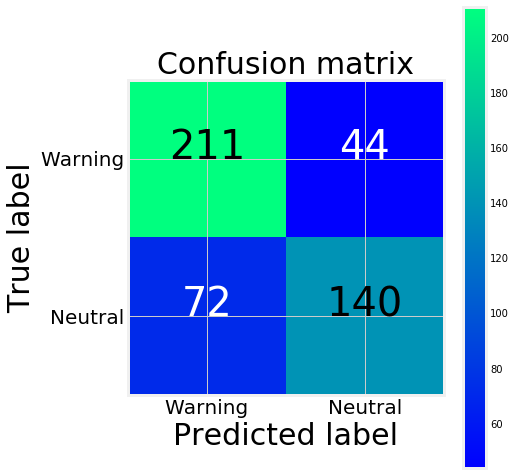

[[211  44]
 [ 72 140]]


In [457]:
cm = confusion_matrix(y_test_class, y_preds_tfidf)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['Warning','Neutral'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

[[211  44]
 [ 72 140]]


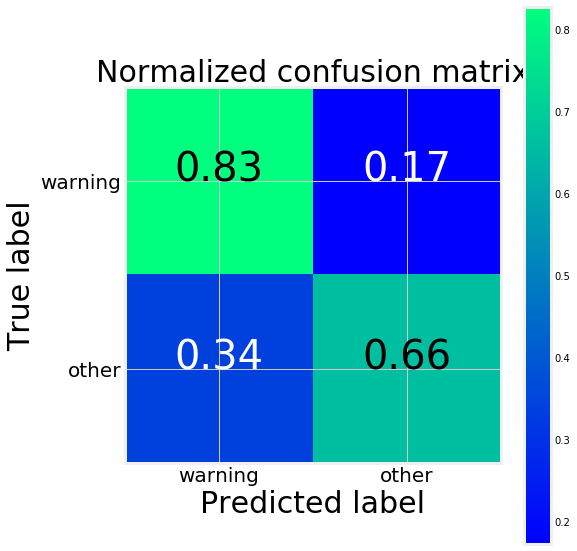

In [458]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_class, y_preds_tfidf)
np.set_printoptions(precision=2)
print(cnf_matrix)

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['warning','other'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

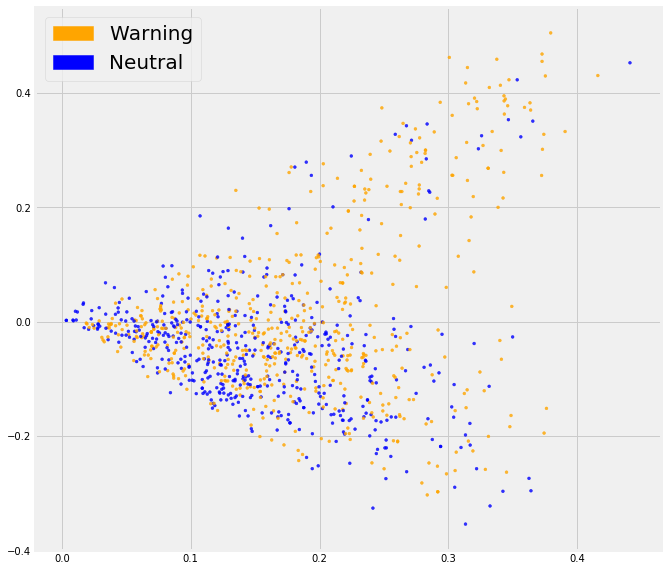

In [459]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
from matplotlib import patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Warning')
            green_patch = mpatches.Patch(color='blue', label='Neutral')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf_class, y_train_class)
plt.show()

In [460]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [461]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Warnings', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Neutral', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [462]:
sgdc_binary = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
sgdc_binary.fit(X_train_tfidf_class, y_train_class)



SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [463]:
Y_pp = pd.DataFrame(sgdc_binary.predict_proba(X_test_tfidf_class), columns=['warning_pp','neutral_pp'])
Y_pp.head(10)

,warning_pp,neutral_pp
0,0.409852,0.590148
1,0.416566,0.583434
2,0.935377,0.064623
3,0.483659,0.516341
4,0.388862,0.611138
5,0.686584,0.313416
6,0.855587,0.144413
7,0.809646,0.190354
8,0.303032,0.696968
9,0.215686,0.784314


In [464]:
def threshold(th):
    Y_pp['outcome'] = [1 if x >= th else 0 for x in Y_pp.neutral_pp.values]
    fn = np.sum((y_test_class == 0) & (Y_pp.outcome == 1))
    return fn

In [465]:
for i in np.linspace(0.15,0.85,10):
    print(i,':',threshold(i))

0.15 : 42
0.22777777777777777 : 36
0.3055555555555556 : 31
0.3833333333333333 : 25
0.46111111111111114 : 22
0.5388888888888889 : 19
0.6166666666666667 : 16
0.6944444444444445 : 13
0.7722222222222223 : 12
0.85 : 8


In [466]:
from sklearn.metrics import roc_curve, auc

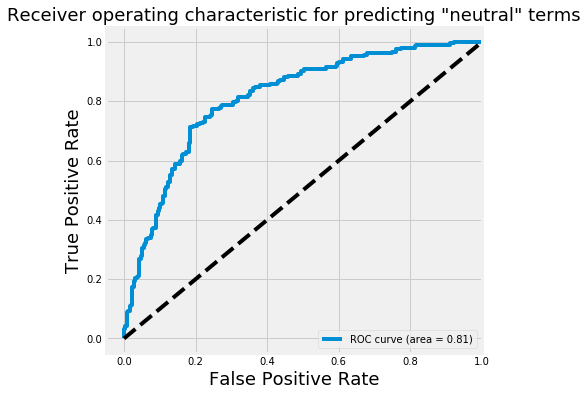

In [467]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test_class, Y_pp.neutral_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (female)
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for predicting "neutral" terms', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [468]:
importance_tfidf = get_most_important_features(tfidf_class, sgdc_binary, 10)

In [469]:
importance_tfidf

{0: {'tops': [(3.3411205370146693, 'choice'),
   (3.471513541921974, 'link'),
   (3.6097605692303714, 'll'),
   (3.696054398971021, 'personal'),
   (3.800936253443475, 'text'),
   (3.803147487657937, 'opt'),
   (4.046922394938707, 'copyright'),
   (4.12682422913801, 'doe'),
   (4.246081463862045, 'identifying'),
   (4.8260919070356145, 'ownership')],
  'bottom': [(-3.0050689529248213, 'described'),
   (-3.0526183133623515, 'virtual'),
   (-3.0666297187767873, 'company'),
   (-3.0851518383983945, 'disclose'),
   (-3.138570793082263, 'service'),
   (-3.328932985709471, 'reason'),
   (-3.409861013179411, 'reserve'),
   (-3.521950364951665, 'damage'),
   (-3.658884230606184, 'activity'),
   (-4.139427368326431, 'advertiser')]}}

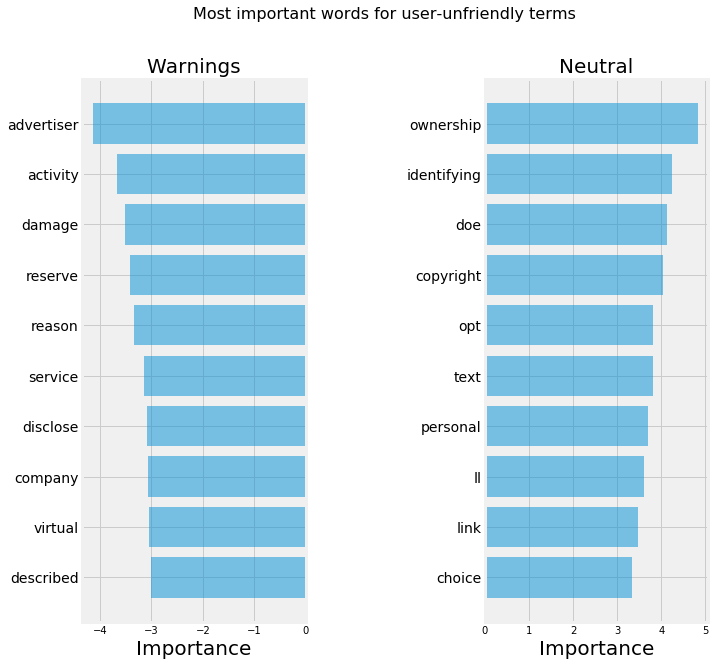

In [470]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for user-unfriendly terms")

In [471]:
topic_class= pd.DataFrame(conf_dict1)
topic_class = topic_class[topic_class.true_topic != topic_class.pred_topic]

In [472]:
warn_class= pd.DataFrame(conf_dict2)
warn_class = warn_class[warn_class.true_class != warn_class.pred_class]

In [473]:
double_wrong = pd.merge(topic_class, warn_class, left_index=True, right_index=True)

In [474]:
quotes = df[['quoteText']]

In [475]:
double_wrong_quotes = pd.merge(double_wrong, quotes, left_index=True, right_index=True)

In [476]:
double_wrong_quotes

,true_topic,pred_topic,true_class,pred_class,quoteText
526,Governance,Waiving your right,1,0,No recovery may be sought or received for dama...
1425,Personal Data,Right to leave the service,0,1,"If you have created a user account, you bear ..."
505,Personal Data,Logs,1,0,"IP Logging:</strong> By default, ProtonMail do..."
810,Governance,Scope of the copyright licence,1,0,"Unless otherwise specified, the Services are f..."
10,Suspension and Censorship,Governance,1,0,"""Should users do not lower the bandwidth despi..."
905,Anonymity and Tracking,Cookies,0,1,COOKIES: Cooies help us in many ways to make y...
1000,Scope of the copyright licence,Personal Data,0,1,The core data of the database is licensed unde...
16,Changes to Terms,Governance,1,0,we believe that community input is essential f...
323,Changes to Terms,Personal Data,0,1,> For revisions to this Privacy Policy that ma...
1657,Guarantee,Personal Data,0,1,We do not guarantee that any of the informatio...


In [477]:
for i in double_wrong_quotes.index:
    print(double_wrong_quotes.quoteText[i])
    print()
    print("Originally classified as: ", double_wrong_quotes.true_topic[i])
    print("Predicted as: ", double_wrong_quotes.pred_topic[i])
    print("Predicted neutral?: ", double_wrong_quotes.pred_class[i])
    print()
    print()

No recovery may be sought or received for damages other than out-of-pocket expenses, except that the prevailing party will be entitled to costs and attorneys’ fees.
In the event of any controversy or dispute between Apple and you arising out of or in connection with your use of the Site, the parties shall attempt, promptly and in good faith, to resolve any such dispute.
If we are unable to resolve any such dispute within a reasonable time (not to exceed thirty (30) days), then either party may submit such controversy or dispute to mediation.
If the dispute cannot be resolved through mediation, then the parties shall be free to pursue any right or remedy available to them under applicable law.</p>

Originally classified as:  Governance
Predicted as:  Waiving your right
Predicted neutral?:  0


 If you have created a user account, you bear the sole responsibility for information that you fill in when registering or when modifying your account.

Originally classified as:  Personal Data
Pr

## Evaluation & next steps

The score of 0.67 compared to 0.11 baseline for classifying by topic is relatively positively, considering there are 19 topics. The good/bad classification of 0.75 is also promising, although less impressive compared to the baseline of 0.54 for the binary prediction.

There are two areas for next steps:
    1. Improving the model
    2. Building a proof of concept for a classification tool

While there are conceivably other options to try in terms of NLP models (Doc2Vec in particular), the overall performance is unlikely to be much improved without a better dataset. For example - more data - but also better-classified data. It is clear from some of the misclassifications that the model understandably chooses some topics whereas a human has chosen another. Because of the subjective nature of classifying into topic, it is difficult to say in every case that the human classifier is correct and the model is wrong. The subject could benefit from a review of the classification and perhaps a new framework for topics/meaning, but this would be a much larger undertaking.

However, this does not invalidate the exercise, and my further plan is to create a front-end proof of concept using Flask, with the following workflow:
* accept input from a URL of a Terms of Service / Privacy Policy document
* scrape the page and split the document by logical separator (eg. paragraph break) into separate snippets/observations
* use the warning/neutral classifer to identify which paragraphs are of potential interest to a user
* predict the topic of those selected paragraphs and display them to the user in a categorised output
* potentially - explore using GenSim summariser to present a summarized version of the paragraph as well

This would present a simple tool for important/concerning terms to be highlighted and displayed without the user having to read the document in full. The model could then be further enhanced with improvements to the training set.

In [478]:
import requests
from readability import Document

In [479]:
url = 'https://www.forghetti.com/eng/terms-of-service'

In [480]:
response = requests.get(url)
doc = Document(response.text)

In [481]:
doc.title()

'Terms of Service - forghetti™ - Forget your passwords. Forever.'

In [482]:
doc.summary(html_partial=True)

'<div><div class="sqs-block-content"><p>\xa0</p><h1>forghetti™ Terms of Service</h1><h2>Thank you for choosing to use the forghetti platform!</h2><p>Please read these terms of service (“Terms”) carefully because it sets forth legal rights and obligations and cover your use and access to our services, client software and websites ("Services").</p><h3>1. APPLICATION OF THIS AGREEMENT</h3><p>If you subscribe to the service for a defined period of time (the “Initial Term”), then, unless you decline to renew your subscription in accordance with the below, this Terms of Use Agreement will be automatically renewed for additional periods of the same duration as the Initial Term at Forghetti’s then-current rates for such Service.</p><h3>2. DEFINITIONS</h3><p>“Agreement” refers to these Terms of Service;</p><p>“App(s)” refers to our mobile, desktop and browser applications made available to you through Apple AppStore, Google Play, Android Marketplace or other app stores or indeed the Forghetti w

In [483]:
full_text = doc.summary(html_partial=True)

In [484]:
full_text = full_text.replace(r"\n", " ")
full_text = full_text.replace(r"\t", " ")
full_text = full_text.replace(r"/", " ")

In [485]:
import re

TAG_RE = re.compile(r'<[^>][^>]+>')

def remove_tags(text):
    return TAG_RE.sub(' ', text)

In [486]:
full_text = remove_tags(full_text)

In [487]:
term_list = full_text.split('<p>')

In [488]:
term_list_check = []
for i in term_list:
    if len(i) > 50:
        term_list_check.append(i)

In [489]:
term_list_check

['\xa0  forghetti™ Terms of Service  Thank you for choosing to use the forghetti platform! ',
 'Please read these terms of service (“Terms”) carefully because it sets forth legal rights and obligations and cover your use and access to our services, client software and websites ("Services").  1. APPLICATION OF THIS AGREEMENT ',
 'If you subscribe to the service for a defined period of time (the “Initial Term”), then, unless you decline to renew your subscription in accordance with the below, this Terms of Use Agreement will be automatically renewed for additional periods of the same duration as the Initial Term at Forghetti’s then-current rates for such Service.  2. DEFINITIONS ',
 '“App(s)” refers to our mobile, desktop and browser applications made available to you through Apple AppStore, Google Play, Android Marketplace or other app stores or indeed the Forghetti website; ',
 '“Forghetti” refers to one of the following: our company (the official name of which is “Forghetti Ltd.”); ou

In [490]:
term_frame = pd.DataFrame(term_list_check, columns = ['quoteText'])

In [491]:
term_frame

,quoteText
0,forghetti™ Terms of Service Thank you for ...
1,Please read these terms of service (“Terms”) c...
2,If you subscribe to the service for a defined ...
3,"“App(s)” refers to our mobile, desktop and bro..."
4,“Forghetti” refers to one of the following: ou...
5,“Registered User” refers to a User who has reg...
6,“Service” or “Services” refers to the services...
7,“Website” refers to any website controlled by ...
8,"“You” (whether or not capitalised, and includi..."
9,"Forghetti is a digital platform (mobile, deskt..."


In [492]:
term_frame['tokens'] = term_frame['quoteText'].apply(tokenizer.tokenize)
# created a tokens column for future use

lemmatizer = WordNetLemmatizer()

# apply lemmatizer to each cell and return as string for use with Count Vectorizer and other methods
def lemmatize_block(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return " ".join(lemma_words)

term_frame['lemmatized'] = term_frame.tokens.apply(lemmatize_block)

In [493]:
term_frame

,quoteText,tokens,lemmatized
0,forghetti™ Terms of Service Thank you for ...,"[forghetti, Terms, of, Service, Thank, you, fo...",forghetti term of service thank you for choosi...
1,Please read these terms of service (“Terms”) c...,"[Please, read, these, terms, of, service, Term...",please read these term of service term careful...
2,If you subscribe to the service for a defined ...,"[If, you, subscribe, to, the, service, for, a,...",if you subscribe to the service for a defined ...
3,"“App(s)” refers to our mobile, desktop and bro...","[App, s, refers, to, our, mobile, desktop, and...",app s refers to our mobile desktop and browser...
4,“Forghetti” refers to one of the following: ou...,"[Forghetti, refers, to, one, of, the, followin...",forghetti refers to one of the following our c...
5,“Registered User” refers to a User who has reg...,"[Registered, User, refers, to, a, User, who, h...",registered user refers to a user who ha regist...
6,“Service” or “Services” refers to the services...,"[Service, or, Services, refers, to, the, servi...",service or service refers to the service that ...
7,“Website” refers to any website controlled by ...,"[Website, refers, to, any, website, controlled...",website refers to any website controlled by u ...
8,"“You” (whether or not capitalised, and includi...","[You, whether, or, not, capitalised, and, incl...",you whether or not capitalised and including v...
9,"Forghetti is a digital platform (mobile, deskt...","[Forghetti, is, a, digital, platform, mobile, ...",forghetti is a digital platform mobile desktop...


In [494]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train['lemmatized'])
X_train_tfidf = tfidf.transform(X_train['lemmatized'])
X_world_tfidf = tfidf.transform(term_frame['lemmatized'])

In [495]:
lr_tfidf = LogisticRegression(C=100.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial',
                          random_state=7)
lr_tfidf.fit(X_train_tfidf, y_train_topic)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=7, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [496]:
world_preds = lr_tfidf.predict(X_world_tfidf)

In [497]:
world_topic = pd.DataFrame(world_preds, columns =['pred_topic'])

#### Class prediction

In [498]:
X_world_tfidf_class = tfidf_class.transform(term_frame['lemmatized'])

In [499]:
sgdc_binary = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
sgdc_binary.fit(X_train_tfidf_class, y_train_class)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [500]:
Y_world_pp = pd.DataFrame(sgdc_binary.predict_proba(X_world_tfidf_class), columns=['warning_pp','neutral_pp'])
Y_world_pp.head(10)

,warning_pp,neutral_pp
0,0.292799,0.707201
1,0.314714,0.685286
2,0.422054,0.577946
3,0.718284,0.281716
4,0.805608,0.194392
5,0.334948,0.665052
6,0.734512,0.265488
7,0.448898,0.551102
8,0.516698,0.483302
9,0.652405,0.347595


In [501]:
scrape_results = pd.merge(term_frame, world_topic, left_index=True, right_index=True)
scrape_res_final = pd.merge(scrape_results, Y_world_pp, left_index=True, right_index=True)

In [502]:
scrape_res_final

,quoteText,tokens,lemmatized,pred_topic,warning_pp,neutral_pp
0,forghetti™ Terms of Service Thank you for ...,"[forghetti, Terms, of, Service, Thank, you, fo...",forghetti term of service thank you for choosi...,Governance,0.292799,0.707201
1,Please read these terms of service (“Terms”) c...,"[Please, read, these, terms, of, service, Term...",please read these term of service term careful...,Governance,0.314714,0.685286
2,If you subscribe to the service for a defined ...,"[If, you, subscribe, to, the, service, for, a,...",if you subscribe to the service for a defined ...,Changes to Terms,0.422054,0.577946
3,"“App(s)” refers to our mobile, desktop and bro...","[App, s, refers, to, our, mobile, desktop, and...",app s refers to our mobile desktop and browser...,Cookies,0.718284,0.281716
4,“Forghetti” refers to one of the following: ou...,"[Forghetti, refers, to, one, of, the, followin...",forghetti refers to one of the following our c...,Governance,0.805608,0.194392
5,“Registered User” refers to a User who has reg...,"[Registered, User, refers, to, a, User, who, h...",registered user refers to a user who ha regist...,Governance,0.334948,0.665052
6,“Service” or “Services” refers to the services...,"[Service, or, Services, refers, to, the, servi...",service or service refers to the service that ...,Personal Data,0.734512,0.265488
7,“Website” refers to any website controlled by ...,"[Website, refers, to, any, website, controlled...",website refers to any website controlled by u ...,User information,0.448898,0.551102
8,"“You” (whether or not capitalised, and includi...","[You, whether, or, not, capitalised, and, incl...",you whether or not capitalised and including v...,Personal Data,0.516698,0.483302
9,"Forghetti is a digital platform (mobile, deskt...","[Forghetti, is, a, digital, platform, mobile, ...",forghetti is a digital platform mobile desktop...,Anonymity and Tracking,0.652405,0.347595


In [503]:
res = scrape_res_final.sort_values('neutral_pp').head(10)

In [505]:
res[res['pred_topic'] == 'Governance']

,quoteText,tokens,lemmatized,pred_topic,warning_pp,neutral_pp
41,"If anyone brings a claim (""Third Party Claim"")...","[If, anyone, brings, a, claim, Third, Party, C...",if anyone brings a claim third party claim aga...,Governance,0.979172,0.020828
52,"(c) If the performance of this Agreement, or a...","[c, If, the, performance, of, this, Agreement,...",c if the performance of this agreement or any ...,Governance,0.845232,0.154768
4,“Forghetti” refers to one of the following: ou...,"[Forghetti, refers, to, one, of, the, followin...",forghetti refers to one of the following our c...,Governance,0.805608,0.194392


In [506]:
topics_in_this_extract = []
for i in res['pred_topic']:
    if i not in topics_in_this_extract:
        topics_in_this_extract.append(i)

In [507]:
dd = {'Waiving your right': 'You might be giving up some of your consumer or legal rights',
      'Business Transfers': 'Your data might be a transferable business asset',
     'Changes to Terms': 'You may not be notified in the event of changes, or those changes might be unfavourable',
     'Anonymity and Tracking':'The service may be tracking you in unexpected ways',
      'Content':'If the service allows you to upload content, you may wish to check these terms to see how it may be used.',
      'Cookies':'Cookies are files stored locally in your web browser containing identifiable information. This service may use them in ways you might not like.',
      'Governance':'Your relationship with the service and the community: this is a broad spectrum but there may be concerning terms.',
      'Guarantee':'Your guarantees may be limited.',
      'Jurisdiction and governing laws':'Possible concern over the governing law for this service.',
      'Law and government requests':'This service may not behave favourably or with transparency towards you, if government requests are received.',
      'Logs':'The service may keep a significant record of your activity, or be less-than-transparent about it.',
      'Ownership':'The content and the data you generate on services online is usually subject to copyright law: you may wish to check the service has the same view',
      'Personal Data':'Your personal data may be used in unexpected ways and you may not have control of it once given.',
      'Right to leave the service':'It may be difficult to leave this service or delete your data.',
      'Scope of the copyright licence':'The copyright license may be so broad that your content can be exploited by others without asking you',
      'Suspension and Censorship':'The service may be suspended or your lawful content removed without warning or recourse.',
      'User information':'Terms that may contain noteworthy information',
      'Third Parties':'Third parties may be involved in operating the service or otherwise be in receipt of your data',
      'User choice':'These terms may give you some choice, or an illusion of choice'}

In [508]:
topics_in_this_extract

['Governance',
 'Guarantee',
 'Personal Data',
 'Suspension and Censorship',
 'Changes to Terms']

In [524]:
for i in topics_in_this_extract:
    topic = res[res['pred_topic'] == i]
    print(i)
    print(dd[i])
    count = 0
    for j in topic.index:
        count +=1
        print()
        print(count,'. ', topic.quoteText[j])
        print()
    print('---')

Governance
Your relationship with the service and the community: this is a broad spectrum but there may be concerning terms.

1 .  If anyone brings a claim ("Third Party Claim") against us related to your actions, information, or content on Forghetti, you will, to the extent permitted by law, indemnify and hold the Forghetti harmless from and against all liabilities, damages, losses, and expenses of any kind (including reasonable legal fees and costs) relating to, arising out of, or in any way in connection with any of the following: (a) your access to or use of our Services, including information provided in connection therewith; (b) your breach of our Terms or of applicable law; or (c) any misrepresentation made by you. You will cooperate as fully as required by us in the defence or settlement of any Third Party Claim. Your rights with respect to Forghetti are not modified by the foregoing indemnification if the laws of your country of residence, applicable as a result of your use of

In [527]:
def print_results(threshold):
    res = scrape_res_final[scrape_res_final.warning_pp > threshold].sort_values('neutral_pp')
    for i in res.index:
        print("Category: ", scrape_res_final['pred_topic'][i])
        print(scrape_res_final.quoteText[i])
        print()
        print()

In [528]:
print_results(0.8)

Category:  Governance
If anyone brings a claim ("Third Party Claim") against us related to your actions, information, or content on Forghetti, you will, to the extent permitted by law, indemnify and hold the Forghetti harmless from and against all liabilities, damages, losses, and expenses of any kind (including reasonable legal fees and costs) relating to, arising out of, or in any way in connection with any of the following: (a) your access to or use of our Services, including information provided in connection therewith; (b) your breach of our Terms or of applicable law; or (c) any misrepresentation made by you. You will cooperate as fully as required by us in the defence or settlement of any Third Party Claim. Your rights with respect to Forghetti are not modified by the foregoing indemnification if the laws of your country of residence, applicable as a result of your use of our Services, do not permit it.  13. CONFIDENTIALITY 


Category:  Guarantee
Forghetti will not be liable fo

Create a function from the above

In [556]:
def key_terms(url, thresh):
    response = requests.get(url)
    doc = Document(response.text)
    full_text = doc.summary(html_partial=True)
    full_text = full_text.replace(r"\n", " ")
    full_text = full_text.replace(r"\t", " ")
    full_text = full_text.replace(r"/", " ")
    full_text = remove_tags(full_text)
    term_list = full_text.split('<p>')
    term_list_check = []
    for i in term_list:
        if len(i) > 50:
            term_list_check.append(i)
    term_frame = pd.DataFrame(term_list_check, columns = ['quoteText'])
    term_frame['tokens'] = term_frame['quoteText'].apply(tokenizer.tokenize)
    term_frame['lemmatized'] = term_frame.tokens.apply(lemmatize_block)
    X_world_tfidf = tfidf.transform(term_frame['lemmatized'])
#     lr_tfidf.fit(X_train_tfidf, y_train_topic)
    world_preds = lr_tfidf.predict(X_world_tfidf)
    world_topic = pd.DataFrame(world_preds, columns =['pred_topic'])
    X_world_tfidf_class = tfidf_class.transform(term_frame['lemmatized'])
#     sgdc_binary.fit(X_train_tfidf_class, y_train_class)
    Y_world_pp = pd.DataFrame(sgdc_binary.predict_proba(X_world_tfidf_class), columns=['warning_pp','neutral_pp'])
    scrape_results = pd.merge(term_frame, world_topic, left_index=True, right_index=True)
    scrape_res_final = pd.merge(scrape_results, Y_world_pp, left_index=True, right_index=True)
    res = scrape_res_final[scrape_res_final.warning_pp > thresh].sort_values('neutral_pp').head(10)
    print("Thanks for using the Terms Classifier. The title of the analysed extract is:")
    print('"'+doc.title()+'"')
    print()
    print("The terms have been analysed! You might want to pay attention to the following:")
    print()
    topics_in_this_extract = []
    for i in res['pred_topic']:
        if i not in topics_in_this_extract:
            topics_in_this_extract.append(i)
    for i in topics_in_this_extract:
        topic = res[res['pred_topic'] == i]
        print(i)
        print(dd[i])
        count = 0
        for j in topic.index:
            count +=1
            print()
            print(count,'. ', topic.quoteText[j])
            print()
        print('---')

In [564]:
forghetti = 'https://www.forghetti.com/eng/terms-of-service'
neko_atsume = 'http://nekoatsume.com/en/kiyaku.html'
stardew_valley = 'https://www.stardewvalley.net/terms/'

In [565]:
key_terms(stardew_valley, 0.7)

Thanks for using the Terms Classifier. The title of the analysed extract is:
"Stardew Valley - Terms of Use"

The terms have been analysed! You might want to pay attention to the following:

Governance
Your relationship with the service and the community: this is a broad spectrum but there may be concerning terms.

1 .  You agree to defend, indemnify, and hold harmless the Company, its affiliates, licensors, and service providers, and its and their respective officers, directors, employees, contractors, agents, licensors, suppliers, successors, and assigns from and against any claims, liabilities, damages, judgments, awards, losses, costs, expenses, or fees (including reasonable attorneys’ fees) arising out of or relating to your violation of these Terms of Use or your use of the Services, including the Websites. 



2 .    
 
 Otherwise attempt to interfere with the proper working of the Services, including the Websites. 
 



3 .    
 
 Disable, overburden, damage, or impair (or atte